# Part 1

In [ ]:
# Optional Starter Code for Final Exam Project

# not mandatory to be used, you can start with your own codes

# Import libraries
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import math
import scipy.stats as scs
! pip install cplex
import cplex
import cvxpy as cp
import statsmodels.api as smf

# Import other libraries
# Insert your code here #

# Read Daily Prices

# CSV file with price data
input_file_prices  = 'Daily_closing_prices.csv'
if path.exists(input_file_prices):
    print('\nReading daily prices datafile - {}\n'.format(input_file_prices))
    fid = pd.read_csv(input_file_prices)
    # instrument tickers
    tickers = list(fid.columns)[1:]
    # time periods
    dates = fid['Date']
    data_prices = fid.values[:,1:]
    data_prices=data_prices.astype('float')
else:
    print("No such file '{}'".format(input_file_prices), file=sys.stderr)
    
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(fid['Date'].apply(convert_date_to_array)))

# Question 1

# Specify quantile level for VaR/CVaR
alf = 0.95

# Number of assets in universe
Na = data_prices.shape[1]

# Number of historical scenarios
Ns = data_prices.shape[0]

# Positions in the portfolio
positions = np.array([100, 0, 0, 0, 0, 0, 0, 0, 200, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(Na,1)

################################ Insert your code here ################################
# calculate initial portfolio value
portf_value_init=(np.dot(data_prices[0,:],positions)).astype('float')
# calculate portfolio value for each trading day
portf_value=np.dot(data_prices,positions)
# calcualte 1-day loss 
diff_1d=portf_value[:-1]-portf_value[1:]
loss_1d=np.sort(diff_1d.reshape(-1)).astype('float')
# calcualte 10-day loss
# calculate number of windows 
num_wind=data_prices.shape[0]-10
# initialize the 10-day loss array
diff_10d=np.zeros((num_wind))
# iterate through each window and calcualte loss
for i in range(1,num_wind+1):
    diff_10d[i-1]=portf_value[i-1]-portf_value[i+9]
loss_10d=np.sort(diff_10d)
# numebr of scenarios for each case
Ns_1=Ns-1
Ns_10=Ns-10
# compute 1-day VaR using historical data
VaR1 = loss_1d[int(math.ceil(Ns_1 * alf)) - 1]
# compute 1-day CVaR using historical data
CVaR1 = (1 / (Ns_1 * (1 - alf))) * ((math.ceil(Ns_1 * alf) - Ns_1 * alf) * VaR1 + sum(loss_1d[int(math.ceil(Ns_1 * alf)):]))
# compute 10-day VaR using historical data
VaR10 = loss_10d[int(math.ceil(Ns_10 * alf)) - 1]
# compute 10-day CVaR using historical data
CVaR10 = (1 / (Ns_10 * (1 - alf))) * ((math.ceil(Ns_10 * alf) - Ns_10 * alf) * VaR10 + sum(loss_10d[int(math.ceil(Ns_10 * alf)):]))
# calculate portfolio weight
w=(data_prices[0,:]*positions.reshape(-1))/np.dot(data_prices[0,:],positions)
# calcualte mean and covariance for each stock from historical data for 1-day
return_1d=((data_prices[1:,:] / data_prices[:-1,:])- 1).astype('float')
mu_1d = -np.mean(return_1d, axis = 0)
Q_1d = np.cov(return_1d.T)
# calculate portfolio mean and variance for 1-day
portf_mean_1d=np.dot(mu_1d.T,w)*portf_value_init
portf_var_1d=np.dot(w.T,Q_1d).dot(w)*portf_value_init**2
# calculate VaR and CVaR using normal distribution of loss
VaR1n=portf_mean_1d+scs.norm.ppf(alf)*np.sqrt(portf_var_1d)
CVaR1n=portf_mean_1d + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * np.sqrt(portf_var_1d)
# calcualte mean and covariance for each stock from historical data for 10-day
return_10d=np.zeros((num_wind,Na))
# iterate throug each window and calculate return 
for i in range(1,1+num_wind):
    return_10d[i-1]=(data_prices[i+9,:] / data_prices[i-1,:])- 1
# calcualte mean and covariance for each stock from historical data for 10-day
mu_10d = -np.mean(return_10d, axis = 0)
Q_10d = np.cov(return_10d.T)
# calculate portfolio mean and variance for 10-day
portf_mean_10d=np.dot(mu_10d.T,w)*portf_value_init
portf_var_10d=np.dot(w.T,Q_10d).dot(w)*portf_value_init**2
# calculate VaR and CVaR using normal distribution of loss
VaR10n=portf_mean_10d+scs.norm.ppf(alf)*np.sqrt(portf_var_10d)
CVaR10n=portf_mean_10d + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * np.sqrt(portf_var_10d)
# print results
print('Historical 1-day VaR %4.1f%% = $%6.2f,   Historical 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1, 100*alf, CVaR1))
print('    Normal 1-day VaR %4.1f%% = $%6.2f,       Normal 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1n, 100*alf, CVaR1n))
print('Historical 10-day VaR %4.1f%% = $%6.2f,   Historical 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10, 100*alf, CVaR10))
print('    Normal 10-day VaR %4.1f%% = $%6.2f,       Normal 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10n, 100*alf, CVaR10n))



Reading daily prices datafile - Daily_closing_prices.csv

Historical 1-day VaR 95.0% = $2477.25,   Historical 1-day CVaR 95.0% = $4326.98

    Normal 1-day VaR 95.0% = $2117.54,       Normal 1-day CVaR 95.0% = $2673.14

Historical 10-day VaR 95.0% = $9023.03,   Historical 10-day CVaR 95.0% = $14099.34

    Normal 10-day VaR 95.0% = $5585.88,       Normal 10-day CVaR 95.0% = $7168.01



Text(0.5, 1.0, 'Distribution of 1-Day Loss')

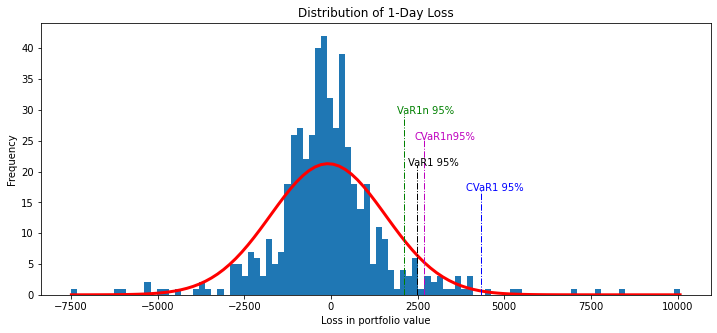

In [ ]:
# plot the result for 1-Day loss
plt.figure(figsize=(12,5))
frequencyCounts, binLocations, patches = plt.hist(loss_1d, 100)
normf= (1 / (np.std(loss_1d) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(loss_1d)) / np.std(loss_1d)) ** 2)
normf= normf* sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaR1, VaR1], [0, 0.5*max(frequencyCounts)], color='k', linewidth=1, linestyle='-.')
plt.text(0.9 * VaR1, 0.5*max(frequencyCounts), 'VaR1 95%',color='k')
plt.plot([VaR1n, VaR1n], [0, 0.7*max(frequencyCounts)], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * VaR1n, 0.7*max(frequencyCounts), 'VaR1n 95%',color='g')
plt.plot([CVaR1, CVaR1], [0, 0.4*max(frequencyCounts)], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaR1, 0.4*max(frequencyCounts), 'CVaR1 95%',color='b')
plt.plot([CVaR1n, CVaR1n], [0, 0.6*max(frequencyCounts)], color='m', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaR1n, 0.6*max(frequencyCounts), 'CVaR1n95%',color='m')
plt.xlabel('Loss in portfolio value')
plt.ylabel('Frequency')
plt.title('Distribution of 1-Day Loss')

Text(0.5, 1.0, 'Distribution of 10-Day Loss')

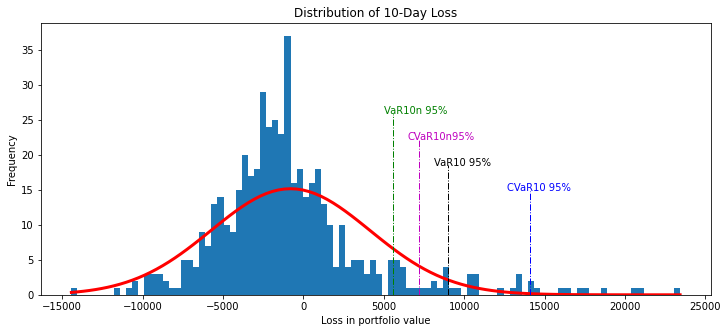

In [ ]:
# plot the result for 10-Day loss
plt.figure(figsize=(12,5))
frequencyCounts, binLocations, patches = plt.hist(loss_10d, 100)
normf= (1 / (np.std(loss_10d) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(loss_10d)) / np.std(loss_10d)) ** 2)
normf= normf* sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaR10, VaR10], [0, 0.5*max(frequencyCounts)], color='k', linewidth=1, linestyle='-.')
plt.text(0.9 * VaR10, 0.5*max(frequencyCounts), 'VaR10 95%',color='k')
plt.plot([VaR10n, VaR10n], [0, 0.7*max(frequencyCounts)], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * VaR10n, 0.7*max(frequencyCounts), 'VaR10n 95%',color='g')
plt.plot([CVaR10, CVaR10], [0, 0.4*max(frequencyCounts)], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaR10, 0.4*max(frequencyCounts), 'CVaR10 95%',color='b')
plt.plot([CVaR10n, CVaR10n], [0, 0.6*max(frequencyCounts)], color='m', linewidth=1, linestyle='-.')
plt.text(0.9 * CVaR10n, 0.6*max(frequencyCounts), 'CVaR10n95%',color='m')
plt.xlabel('Loss in portfolio value')
plt.ylabel('Frequency')
plt.title('Distribution of 10-Day Loss')

In [ ]:
# define positions for 100 MSFT
position_1 = np.array([100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(Na,1)
# define positions for 200 AAPL
position_2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(Na,1)
# define positions for 500 IBM
position_3 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(Na,1)
# stock codes
sc=['MSFT','AAPL','IBM']
# position choices
pc=[position_1,position_2,position_3]
# iterate through each position:
for i in range(3):
    position=pc[i]
    # calculate portfolio value for each trading day
    portf_value=np.dot(data_prices,position)
    # calcualte 1-day loss 
    diff_1d=portf_value[:-1]-portf_value[1:]
    loss_1d=np.sort(diff_1d.reshape(-1))
    # compute 1-day VaR using historical data
    VaR1 = loss_1d[int(math.ceil(Ns * alf)) - 1]
    print('1-Day 95% VaR for {}: {}'.format(sc[i],VaR1))

1-Day 95% VaR for MSFT: 531.8313600000001
1-Day 95% VaR for AAPL: 606.9519200000032
1-Day 95% VaR for IBM: 1838.3407500000103


# Part 2

In [ ]:
# Question 2

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Compute means and covariances for Question 2 (2019 and 2020)
cur_returns = (data_prices[1:,:] / data_prices[:Ns-1,:]) - 1
cur_returns = cur_returns

# Expected returns for Question 2
mu = np.mean(cur_returns, axis=0)
# Covariances for Question 2
Q = np.cov(cur_returns.astype(float).T)


################################ Insert your code here ################################
n=20
#### minimum variance portfolio
w1 = cp.Variable(n)
prob = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)),
                 [sum(w1) == 1,
                  w1 >= 0])
prob.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})
# get solutions
w_minVar=w1.value
# calculate variance and return
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
ret_minVar = np.dot(mu.T, w_minVar.reshape(-1,1))
# ### maximum return portfolio
def strat_max_return(mu):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.maximize)
    n = 20
    c = mu
    lb = np.zeros((n))
    ub = np.ones((n))
    A = []
    for k in range(n):
        A.append([[0],[1]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1], senses="E")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # Get w from solver
    w_maxRet = np.array(cpx.solution.get_values())
    return w_maxRet
# get solutions
w_maxRet=strat_max_return(mu)
# calculate variance and return
var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet))
ret_maxRet = np.dot(mu.T, w_maxRet.reshape(-1,1))
### equally-weighted portfolio
w_eqWeight=1/n*np.ones((n))
# calculate variance and return
var_eqWeight= np.dot(w_eqWeight, np.dot(Q, w_eqWeight))
ret_eqWeight = np.dot(mu.T, w_eqWeight.reshape(-1,1))
### initial portfolio from assignment 1
init_positions=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])
w_a1=(data_prices[0,:]*init_positions)/np.dot(data_prices[0,:],init_positions)
# calculate variance and return
var_a1= np.dot(w_a1, np.dot(Q, w_a1))
ret_a1 = np.dot(mu.T, w_a1.reshape(-1,1))
### maximum sharpe ratio portfolio
def strat_max_Sharpe(mu, Q):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = 21
    c = np.zeros((n))
    lb = np.zeros((n))
    ub = [cplex.infinity]*n
    # Risk-free return is converted to daily
    coef = mu-r_rf/252
    A = []
    for k in range(n-1):
        A.append([[0,1],[coef[k],1]])
    A.append([[1],[-1]])
    # First 20 variables are y
    var_names = ["y_%s" % i for i in range(1,n)]
    # Last variable is kappa
    var_names.append('kappa')
    cpx.linear_constraints.add(rhs=[1,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    # Adjust Q so that it has shape of (21,21)
    Q=np.hstack((Q,np.zeros((20,1))))
    Q=np.vstack((Q,np.zeros((1,21))))
    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # Get optimal solution from solver
    solution = np.array(cpx.solution.get_values())
    # Get the value for y
    y = solution[:20]
    # Get the value for kappa
    kappa = solution[20]
    # Calculate w using formula: w=y/k
    w_max_sharpe = y/kappa
    return w_max_sharpe
w_maxSharpe=strat_max_Sharpe(mu,Q)
# calculate variance and return
var_maxSharpe= np.dot(w_maxSharpe, np.dot(Q, w_maxSharpe))
ret_maxSharpe = np.dot(mu.T, w_maxSharpe.reshape(-1,1))
### risk-free asset
ret_riskFree=r_rf/252
var_riskFree=0

In [ ]:
### efficient frontier
# target returns
targetRet = np.linspace(ret_minVar,ret_maxRet,50)
# compute efficient frontier
w_front = []
var_front = []
ret_front = []
# iterate through each epsilon value to solve the mean-variance optimization problem
for epsilon in targetRet:
    eps = cp.Parameter()
    eps.value = epsilon[0]
    w = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                 [mu.T@w >= eps,
                  sum(w) == 1,
                  w >= 0])
    prob.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})
    w_front.append(w.value)
    var_front.append(np.dot(w.value, np.dot(Q, w.value)))
    ret_front.append(np.dot(mu, w.value))

In [ ]:
### efficient frontier of all assets, shorting allowed (except maximum Sharpe ratio portfolio)
var_front_all = []
ret_front_all= []
# risk-free asset
var_front_all.append(var_riskFree)
ret_front_all.append(ret_riskFree)
# maximum Sharpe ratio portfolio
var_front_all.append(var_maxSharpe)
ret_front_all.append(ret_maxSharpe)
# shorting 
var_front_all.append(4*(var_maxSharpe-var_riskFree))
ret_front_all.append(2*(ret_maxSharpe-ret_riskFree))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


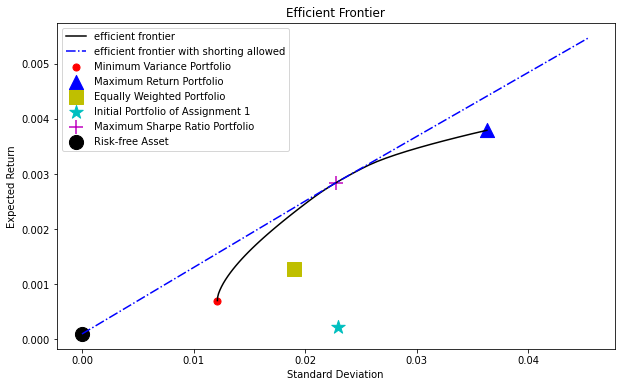

In [ ]:
plt.figure(figsize=(10,6))
# plot efficient frontier
plt.plot(np.sqrt(var_front), ret_front, 'k-', label='efficient frontier')
# plot efficient frontier with shorting allowed
plt.plot(np.sqrt(var_front_all),ret_front_all,'b-.',label='efficient frontier with shorting allowed')
# plot minimum variance portfolio
plt.scatter(np.sqrt(var_minVar),ret_minVar,marker='.',color='r',s=200,label='Minimum Variance Portfolio')
# plot maximum return portfolio
plt.scatter(np.sqrt(var_maxRet),ret_maxRet,marker='^',color='b',s=200,label='Maximum Return Portfolio')
# plot equally weighted portfolio
plt.scatter(np.sqrt(var_eqWeight),ret_eqWeight,marker='s',color='y',s=200,label='Equally Weighted Portfolio')
# plot initial portfolio of assignment 1
plt.scatter(np.sqrt(var_a1),ret_a1,marker='*',color='c',s=200,label='Initial Portfolio of Assignment 1')
# plot maximum Sharpe ratio portfolio
plt.scatter(np.sqrt(var_maxSharpe),ret_maxSharpe,marker='+',color='m',s=200,label='Maximum Sharpe Ratio Portfolio')
# plot risk-free asset
plt.scatter(np.sqrt(var_riskFree),ret_riskFree,marker='o',color='k',s=200,label='Risk-free Asset')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()

In [ ]:
# individual assets
var_ind_asset=[]
ret_ind_asset=[]
# iterate throug each asset to calculate variance and return
for i in range(Na):
    w_ind_asset=np.zeros((Na))
    w_ind_asset[i]=1
    var_ind_asset.append(np.dot(w_ind_asset, np.dot(Q, w_ind_asset)))
    ret_ind_asset.append((np.dot(mu.T, w_ind_asset.reshape(-1,1)))[0])

In [ ]:
# random assets
var_rand_asset=[]
ret_rand_asset=[]
# use normal distribution to randomly generate 1000 portfolios
for i in range(1000):
    w_rand_asset=np.random.uniform(low=0,high=1,size=Na)
    # normalize portfolio weights
    w_rand_asset=w_rand_asset/sum(w_rand_asset)
    # calculate variance and return
    var_rand_asset.append(np.dot(w_rand_asset, np.dot(Q, w_rand_asset)))
    ret_rand_asset.append((np.dot(mu.T, w_rand_asset.reshape(-1,1)))[0])


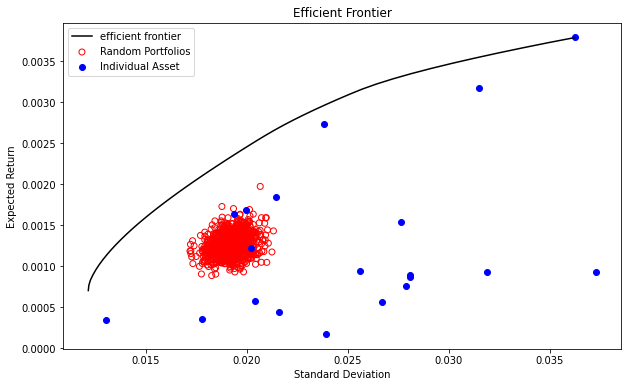

In [ ]:
# plot the result 
plt.figure(figsize=(10,6))
# plot efficient frontier
plt.plot(np.sqrt(var_front), ret_front, 'k-', label='efficient frontier')
# plot random portfolio
plt.scatter(np.sqrt(var_rand_asset),ret_rand_asset,edgecolors='r',facecolors='none',label='Random Portfolios')
# plot individual asset
plt.scatter(np.sqrt(var_ind_asset),ret_ind_asset,c='b',label='Individual Asset')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()

# Part 3

In [ ]:
# Question 3

# Import FF models data from 2019-01-03 to 2020-12-31
input_file_factors  = 'Daily_FF_factors.csv'
if path.exists(input_file_factors):
    print('\nReading daily FF factors datafile - {}\n'.format(input_file_factors))
    ff_data = pd.read_csv(input_file_factors)
    factors_name = list(ff_data.columns)[1:-1]
    rf      = ff_data['RF'][1:].values
    factors = ff_data.values[1:,1:4]
else:
    print("No such file '{}'".format(input_file_factors), file=sys.stderr)

# Indicides helpful to seperate data
# dates[day_ind_start_2019] = '01/02/2019',
# dates[day_ind_end_2019] = '12/31/2019',
# dates[day_ind_start_2019] = '01/02/2020',
# dates[day_ind_end_2019] = '12/31/2019'.
day_ind_start_2019 = 0
day_ind_end_2019   = 251
day_ind_start_2020 = 252
day_ind_end_2020   = 504

data_prices_2019   = data_prices[day_ind_start_2019:day_ind_end_2019+1]
data_prices_2020   = data_prices[day_ind_start_2020:day_ind_end_2020+1]


################################ Insert your code here ################################
### 2019
print("=====2019=====")
beta_im_2019=[]
beta_is_2019=[]
beta_iv_2019=[]
r_squared_2019=[]
for i in range(Na):
    # calculate excess return for stock
    stock_price=data_prices_2019[:,i]
    mu=(stock_price[1:]/stock_price[:-1])-1
    excess_return=(mu-rf[:day_ind_end_2019]).reshape(-1,1)
    # built a dataframe with excess return and each factor
    price_data=np.hstack((excess_return,factors[:day_ind_end_2019,:]))
    df=pd.DataFrame(price_data,columns=['Excess_return','mkt_excess','SMB','HML'])
    # fit OLS model
    model = smf.formula.ols(formula = "Excess_return ~ mkt_excess + SMB + HML", data = df).fit()
    # get parameters
    parameters=model.params
    beta_im_2019.append(parameters[1])
    beta_is_2019.append(parameters[2])
    beta_iv_2019.append(parameters[3])
    # get r-squared
    r_squared_2019.append(model.rsquared)
    # print result
    print('For {}: beta_m = {}, beta_s={}, beta_v={}, r_squared={}'.format(fid.columns[1:][i],parameters[1],parameters[2],parameters[3],model.rsquared))


Reading daily FF factors datafile - Daily_FF_factors.csv

=====2019=====
For MSFT: beta_m = 0.012480072844128106, beta_s=-0.004859607692645325, beta_v=-0.005242779428955639, r_squared=0.7337823258166071
For F: beta_m = 0.010187493732795063, beta_s=0.005504756148659802, beta_v=0.005375969056211562, r_squared=0.3229421614645194
For JPM: beta_m = 0.0113678761041789, beta_s=-0.003082637783191025, beta_v=0.009953493706811837, r_squared=0.7377600155304684
For GOOG: beta_m = 0.01198719160727184, beta_s=-0.00027586950948224354, beta_v=-0.0044312218879372966, r_squared=0.46800834612612685
For HPQ: beta_m = 0.012463107411965322, beta_s=0.0013409947371403204, beta_v=0.0023778843211344773, r_squared=0.2742500436106773
For C: beta_m = 0.015403630925548735, beta_s=-0.001497212794982396, beta_v=0.010720845930835006, r_squared=0.7623875058118523
For HOG: beta_m = 0.014425963619217271, beta_s=0.004634187721593455, beta_v=0.010641314998923653, r_squared=0.48930799355611954
For VZ: beta_m = 0.0035569270

In [ ]:
### 2020
print('=====2020=====')
beta_im_2020=[]
beta_is_2020=[]
beta_iv_2020=[]
r_squared_2020=[]
for i in range(Na):
    # calculate excess return for stock
    stock_price=data_prices_2020[:,i]
    mu=(stock_price[1:]/stock_price[:-1])-1
    excess_return=(mu-rf[day_ind_start_2020:]).reshape(-1,1)
    # built a dataframe with excess return and each factor
    price_data=np.hstack((excess_return,factors[day_ind_start_2020:day_ind_end_2020,:]))
    df=pd.DataFrame(price_data,columns=['Excess_return','mkt_excess','SMB','HML'])
    # fit OLS model
    model = smf.formula.ols(formula = "Excess_return ~ mkt_excess + SMB + HML", data = df).fit()
    # get parameters
    parameters=model.params
    beta_im_2020.append(parameters[1])
    beta_is_2020.append(parameters[2])
    beta_iv_2020.append(parameters[3])
    # get r-squared
    r_squared_2020.append(model.rsquared)
    # print result
    print('For {}: beta_m = {}, beta_s={}, beta_v={}, r_squared={}'.format(fid.columns[1:][i],parameters[1],parameters[2],parameters[3],model.rsquared))

=====2020=====
For MSFT: beta_m = 0.012518377256875445, beta_s=-0.002614750223269624, beta_v=-0.005144902487227577, r_squared=0.8808265273129627
For F: beta_m = 0.008948022830040113, beta_s=0.0012728222249985682, beta_v=0.010015907793933378, r_squared=0.6468421235838635
For JPM: beta_m = 0.010522818886128937, beta_s=-0.002928619773109583, beta_v=0.011201885661469232, r_squared=0.8870157494122171
For GOOG: beta_m = 0.010155256611577942, beta_s=-0.001220508549055984, beta_v=-0.002577563056388577, r_squared=0.7520354323594565
For HPQ: beta_m = 0.010588870039335304, beta_s=0.007336589476292794, beta_v=0.003553261821494109, r_squared=0.6067849065499784
For C: beta_m = 0.012894652174142377, beta_s=-0.0002892194957570515, beta_v=0.013293297570326683, r_squared=0.8704396113597668
For HOG: beta_m = 0.013524329370033212, beta_s=0.003125319903143665, beta_v=0.009000892830972976, r_squared=0.5627757389215909
For VZ: beta_m = 0.0051123005299089745, beta_s=-0.0029299801470087164, beta_v=0.0011839276

In [ ]:
### over 2 years
print('=====2019-2020=====')
intercept_2yr=[]
beta_im_2yr=[]
beta_is_2yr=[]
beta_iv_2yr=[]
r_squared_2yr=[]
for i in range(Na):
    # calculate excess return for stock
    stock_price=data_prices[:,i]
    mu=(stock_price[1:]/stock_price[:-1])-1
    excess_return=(mu-rf).reshape(-1,1)
    # built a dataframe with excess return and each factor
    price_data=np.hstack((excess_return,factors))
    df=pd.DataFrame(price_data,columns=['Excess_return','mkt_excess','SMB','HML'])
    # fit OLS model
    model = smf.formula.ols(formula = "Excess_return ~ mkt_excess + SMB + HML", data = df).fit()
    # get parameters
    parameters=model.params
    beta_im_2yr.append(parameters[1])
    beta_is_2yr.append(parameters[2])
    beta_iv_2yr.append(parameters[3])
    # get r-squared
    r_squared_2yr.append(model.rsquared)
    # get intercept
    intercept_2yr.append(parameters[0])
    # print result
    print('For {}: beta_m = {}, beta_s={}, beta_v={}, r_squared={}'.format(fid.columns[1:][i],parameters[1],parameters[2],parameters[3],model.rsquared))

=====2019-2020=====
For MSFT: beta_m = 0.012502929110072019, beta_s=-0.0028325870454060068, beta_v=-0.005240183656724919, r_squared=0.8366451575784701
For F: beta_m = 0.009341021573092849, beta_s=0.002751677395532611, beta_v=0.009033957543041156, r_squared=0.5712923982996787
For JPM: beta_m = 0.010691658681044616, beta_s=-0.0025388074517624683, beta_v=0.010818373067838501, r_squared=0.8546270570639594
For GOOG: beta_m = 0.010496427864222904, beta_s=-0.000499118896352708, beta_v=-0.003147412465150554, r_squared=0.650872240647149
For HPQ: beta_m = 0.010820833401553615, beta_s=0.006536696289901716, beta_v=0.0032491848407308326, r_squared=0.5107104759709691
For C: beta_m = 0.01331665993683517, beta_s=1.4865345711881161e-05, beta_v=0.012656662800412024, r_squared=0.8467973897027469
For HOG: beta_m = 0.013624732230758553, beta_s=0.003922000818598992, beta_v=0.008912746554944359, r_squared=0.5452905212953478
For VZ: beta_m = 0.0049591060724031195, beta_s=-0.002654094580679865, beta_v=0.000951

In [ ]:
# number of scenarios
N=1000
# initialize daily loss for each asset and the portfolio
loss_msft=np.zeros((N,Ns-1))
loss_aapl=np.zeros((N,Ns-1))
loss_ibm=np.zeros((N,Ns-1))
loss_all=np.zeros((N,Ns-1))
# iterate through each scenario
for s in range(N):
    # initialize portfolio value for each asset
    portf_value_msft=np.zeros(Ns)
    portf_value_aapl=np.zeros(Ns)
    portf_value_ibm=np.zeros(Ns)
    # calcualte initial portfolio value of each asset
    portf_value_msft[0]=100*data_prices[0,0]
    portf_value_aapl[0]=200*data_prices[0,8]
    portf_value_ibm[0]=500*data_prices[0,9]
    # create random number for each factor
    f_m_excess=np.sqrt(2.6999)*np.random.randn(Ns-1,1)
    f_s=np.sqrt(0.5005)*np.random.randn(Ns-1,1)
    f_v=np.sqrt(1.4790)*np.random.randn(Ns-1,1)
    # define correlation matrix
    cor=np.array([[1,0.1351,0.4893],[0.1351,1,0.2170],[0.4893,0.2170,1]])
    # calculate correlated factors
    f=np.hstack((f_m_excess,f_s,f_v))
    sqrt_cor = np.linalg.cholesky(cor)
    f=np.dot(f,sqrt_cor)
    # iterate through each trading day during 2019-2020
    for i in range(Ns-1):
        # calculate return using FF model with beta and alpha obtained from last part
        r_msft=beta_im_2yr[0]*f[i,0]+beta_is_2yr[0]*f[i,1]+beta_iv_2yr[0]*f[i,2]+rf[i]+np.random.randn()/(100*252)+intercept_2yr[0]
        r_aapl=beta_im_2yr[8]*f[i,0]+beta_is_2yr[8]*f[i,1]+beta_iv_2yr[8]*f[i,2]+rf[i]+np.random.randn()/(100*252)+intercept_2yr[8]
        r_ibm=beta_im_2yr[9]*f[i,0]+beta_is_2yr[9]*f[i,1]+beta_iv_2yr[9]*f[i,2]+rf[i]+np.random.randn()/(100*252)+intercept_2yr[9]
        # calcualte daily portfolio value
        portf_value_msft[i+1]=portf_value_msft[i]*(1+r_msft)
        portf_value_aapl[i+1]=portf_value_aapl[i]*(1+r_aapl)
        portf_value_ibm[i+1]=portf_value_ibm[i]*(1+r_ibm)
    # calcualte daily portfolio loss
    l_msft=(portf_value_msft[:-1]-portf_value_msft[1:])
    l_aapl=(portf_value_aapl[:-1]-portf_value_aapl[1:])
    l_ibm=(portf_value_ibm[:-1]-portf_value_ibm[1:])
    l_all=l_msft+l_aapl+l_ibm
    # store result in loss matrix
    loss_msft[s]=l_msft
    loss_aapl[s]=l_aapl
    loss_ibm[s]=l_ibm
    loss_all[s]=l_all

In [ ]:
# calculate VaR at 95%
VaR_msft=np.sort(loss_msft.reshape(-1))[int(math.ceil(N*(Ns-1) * alf)) - 1]
VaR_aapl=np.sort(loss_aapl.reshape(-1))[int(math.ceil(N*(Ns-1) * alf)) - 1]
VaR_ibm=np.sort(loss_ibm.reshape(-1))[int(math.ceil(N*(Ns-1) * alf)) - 1]
VaR_all=np.sort(loss_all.reshape(-1))[int(math.ceil(N*(Ns-1) * alf)) - 1]
# print results
print('1-Day 95% VaR of 100 MSFT: {}'.format(VaR_msft))
print('1-Day 95% VaR of 200 AAPL: {}'.format(VaR_aapl))
print('1-Day 95% VaR of 500 IBM: {}'.format(VaR_ibm))
print('1-Day 95% VaR of all above: {}'.format(VaR_all))

1-Day 95% VaR of 100 MSFT: 668.0694644891046
1-Day 95% VaR of 200 AAPL: 685.042481788756
1-Day 95% VaR of 500 IBM: 2855.9298693305172
1-Day 95% VaR of all above: 4131.330922682166
